setup spikeinterf .. env

In [40]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.utils import get_config
import spikeinterface as si
from src.nodes.metrics.quality import get_scores

# DATASETS

# NPX PROBE
# Synthetic (10m)
cfg, _ = get_config("silico_neuropixels", "stimulus").values()
GT = cfg["sorting"]["simulation"]["ground_truth"]["output"]
KS4 = cfg["sorting"]["sorters"]["kilosort4"]["output"]
KS3 = cfg["sorting"]["sorters"]["kilosort3"]["output"]
KS2_5 = cfg["sorting"]["sorters"]["kilosort2_5"]["output"]
KS2 = cfg["sorting"]["sorters"]["kilosort2"]["output"]
KS = cfg["sorting"]["sorters"]["kilosort"]["output"]
HS = cfg["sorting"]["sorters"]["herdingspikes"]["output"]

DELTA_TIME = 1.3

quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_40m.csv"
score_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/scores/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-09-27 15:28:11,218 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-27 15:28:11,306 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [17]:
# get ten first minutes
SortingTrue = si.load_extractor(GT)

In [18]:
# unit-test
assert (
    si.load_extractor(KS4).get_property("layer") is None
) == False, "run postprocessing"
assert (
    si.load_extractor(KS3).get_property("layer") is None
) == False, "run postprocessing"
assert (
    si.load_extractor(KS2_5).get_property("layer") is None
) == False, "run postprocessing"
# assert (
#     si.load_extractor(KS2).get_property("layer") is None
# ) == False, "run postprocessing"
assert (
    si.load_extractor(KS).get_property("layer") is None
) == False, "run postprocessing"
assert (
    si.load_extractor(HS).get_property("layer") is None
) == False, "run postprocessing"

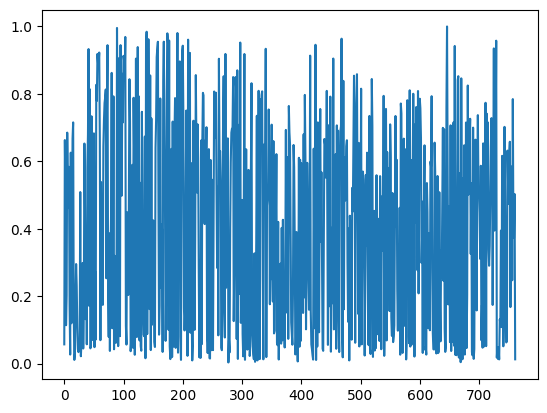

In [19]:
SAVE = True

## KS4
Sorting = si.load_extractor(KS4)
scores4 = get_scores(SortingTrue, Sorting, DELTA_TIME)
# KS3
Sorting = si.load_extractor(KS3)
scores3 = get_scores(SortingTrue, Sorting, DELTA_TIME)
# KS2.5
Sorting = si.load_extractor(KS2_5)
scores25 = get_scores(SortingTrue, Sorting, DELTA_TIME)
# # KS2
# Sorting = si.load_extractor(KS2)
# scores2 = get_scores(SortingTrue, Sorting, DELTA_TIME)
# KS
Sorting = si.load_extractor(KS)
scores1 = get_scores(SortingTrue, Sorting, DELTA_TIME)
# HS
Sorting = si.load_extractor(HS)
scoresH = get_scores(SortingTrue, Sorting, DELTA_TIME)

# save
utils.create_if_not_exists(score_path)
if SAVE:
    scores4.to_csv(score_path + "ks4_40m.csv", index=True)
    scores3.to_csv(score_path + "ks3_40m.csv", index=True)
    scores25.to_csv(score_path + "ks25_40m.csv", index=True)
    # scores2.to_csv(score_path + "ks2_1h.csv", index=True)
    scores1.to_csv(score_path + "ks_40m.csv", index=True)
    scoresH.to_csv(score_path + "hs_40m.csv", index=True)

# plot
plt.plot(scores4.max())

### Sorted unit evaluation

In [41]:
# read quality dataframe
quality_df = pd.read_csv(quality_path)

# report
display("Sorted unit classification table:\n")
display(quality_df)
print("Tested spike sorters:", quality_df["sorter"].unique())

'Sorted unit classification table:\n'

,sorted,quality,layer,sorter,experiment
0,1114,false positive,L5,KS2.5,E
1,197,mixed: good + overmerger + oversplitter,L5,KS,E
2,264,mixed: good + overmerger + oversplitter,L5,KS,E
3,1649,mixed: good + overmerger + oversplitter,L5,KS2.5,E
4,1659,mixed: good + overmerger + oversplitter,L4,KS2.5,E
...,...,...,...,...,...
4701,295,mixed: overmerger + oversplitter,L2/3,KS,E
4702,304,mixed: overmerger + oversplitter,L2/3,HS,E
4703,2762,oversplitter,L5,KS2.5,E
4704,2875,oversplitter,L6,KS,E


Tested spike sorters: ['KS2.5' 'KS' 'HS' 'KS4' 'KS3']


In [36]:
# quick sanity check: proportion of high-quality single-units
# ks4
good_ks4 = quality_df.loc[(quality_df.sorter == "KS4"), "quality"].str.contains("good")
print(sum(good_ks4) / len(good_ks4))
# ks3
good_ks3 = quality_df.loc[(quality_df.sorter == "KS3"), "quality"].str.contains("good")
print(sum(good_ks3) / len(good_ks3))
# ks2.5
good_ks25 = quality_df.loc[(quality_df.sorter == "KS2.5"), "quality"].str.contains(
    "good"
)
print(sum(good_ks25) / len(good_ks25))
# ks
good_ks = quality_df.loc[(quality_df.sorter == "KS"), "quality"].str.contains("good")
print(sum(good_ks) / len(good_ks))
# hs
good_hs = quality_df.loc[(quality_df.sorter == "HS"), "quality"].str.contains("good")
print(sum(good_hs) / len(good_hs))

0.1746031746031746
0.0
0.17391304347826086
0.0392417692051879
0.25245901639344265
